# Reference implementation of Deep Q-Learning

This notebook includes an implementation of the Deep Q-learning algorithm for the Cartpole problem (see [Cartpole documentation](https://gymnasium.farama.org/environments/classic_control/cart_pole/)).


## Libraries

In [35]:
!pip install gymnasium[classic-control]
!pip install "gymnasium[box2d]"
import gymnasium as gym
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import time
import random
import math
from collections import deque



# Reproducibilidad (opcional, pero ayuda a depurar)
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\motac\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\motac\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


## Hyperparameters

In [36]:
# Learning rate (más estable para LunarLander)
LEARNING_RATE = 2.5e-4

# Batch size
BATCH_SIZE = 128

# Discount factor gamma
GAMMA = 0.99

# Size of the replay memory (replay buffer)
MEMORY_SIZE = 200_000

# Warm-up: pasos mínimos antes de empezar a entrenar
WARMUP_STEPS = 5000

# Entrenar cada N pasos de interacción (1 = cada paso)
TRAIN_EVERY = 4

# Exploración epsilon-greedy por PASOS (no por episodio)
EPSILON_START = 1.0
EPSILON_END = 0.02
EPSILON_DECAY_STEPS = 100_000  # lineal hasta EPSILON_END

# Target network (soft update / Polyak)
TAU = 0.005

# Máximo número de episodios de entrenamiento (se para antes si alcanza el objetivo)
MAX_EPISODES_FOR_TRAINING = 2000

# Goal score a alcanzar durante entrenamiento (media de últimos episodios)
TRAINING_GOAL = 200

# Número de episodios usados para comprobar el objetivo durante entrenamiento
EPISODES_TO_CHECK_TRAINING_GOAL = 50

# Número de episodios para evaluar al final
EPISODES_TO_EVALUATE_MODEL_PERFORMANCE = 30

N_STEP = 3
GAMMA_N = GAMMA ** N_STEP


## Class ReplayMemory

Memory of transitions for experience replay.

In [37]:
PER_ALPHA = 0.6          # 0.6 suele ir bien
PER_BETA_START = 0.4     # empieza corrigiendo poco
PER_BETA_FRAMES = 200_000  # sube beta hasta 1.0 a lo largo de steps
PER_EPS = 1e-6

class ReplayMemory:
    def __init__(self, number_of_observations):
        self.states = np.zeros((MEMORY_SIZE, number_of_observations), dtype=np.float32)
        self.states_next = np.zeros((MEMORY_SIZE, number_of_observations), dtype=np.float32)
        self.actions = np.zeros(MEMORY_SIZE, dtype=np.int32)
        self.rewards = np.zeros(MEMORY_SIZE, dtype=np.float32)
        self.dones = np.zeros(MEMORY_SIZE, dtype=np.float32)

        # PER
        self.priorities = np.zeros(MEMORY_SIZE, dtype=np.float32)
        self.max_priority = 1.0

        self.position = 0
        self.current_size = 0

    def store_transition(self, state, action, reward, state_next, done):
        self.states[self.position] = state
        self.states_next[self.position] = state_next
        self.actions[self.position] = action
        self.rewards[self.position] = reward
        self.dones[self.position] = 1.0 if done else 0.0

        # prioridad inicial: máxima para que se samplee pronto
        self.priorities[self.position] = self.max_priority

        self.position = (self.position + 1) % MEMORY_SIZE
        self.current_size = min(self.current_size + 1, MEMORY_SIZE)

    def sample_memory(self, batch_size, beta):
        # prioridades válidas
        prios = self.priorities[:self.current_size]
        probs = prios ** PER_ALPHA
        probs_sum = probs.sum()
        if probs_sum == 0:
            probs = np.ones_like(probs) / len(probs)
        else:
            probs = probs / probs_sum

        idxs = np.random.choice(self.current_size, batch_size, replace=False, p=probs)

        # importance sampling weights
        weights = (self.current_size * probs[idxs]) ** (-beta)
        weights /= weights.max()  # normaliza para estabilidad

        states = self.states[idxs]
        states_next = self.states_next[idxs]
        rewards = self.rewards[idxs]
        actions = self.actions[idxs]
        dones = self.dones[idxs]

        return states, actions, rewards, states_next, dones, idxs, weights.astype(np.float32)

    def update_priorities(self, idxs, new_priorities):
        new_priorities = np.asarray(new_priorities, dtype=np.float32) + PER_EPS
        self.priorities[idxs] = new_priorities
        self.max_priority = max(self.max_priority, float(new_priorities.max()))


## Class DQN

Reinforcement learning agent with a Deep Q-Network.

In [38]:
class RunningMeanStd:
    def __init__(self, shape, eps=1e-4):
        self.mean = np.zeros(shape, dtype=np.float32)
        self.var = np.ones(shape, dtype=np.float32)
        self.count = eps

    def update(self, x):
        x = np.asarray(x, dtype=np.float32)
        batch_mean = x.mean(axis=0)
        batch_var = x.var(axis=0)
        batch_count = x.shape[0] if x.ndim > 1 else 1

        delta = batch_mean - self.mean
        tot_count = self.count + batch_count
        new_mean = self.mean + delta * batch_count / tot_count

        m_a = self.var * self.count
        m_b = batch_var * batch_count
        M2 = m_a + m_b + (delta**2) * self.count * batch_count / tot_count
        new_var = M2 / tot_count

        self.mean, self.var, self.count = new_mean, new_var, tot_count

    def normalize(self, x):
        return (x - self.mean) / (np.sqrt(self.var) + 1e-8)


In [39]:
class DQN:
    def __init__(self, number_of_observations, number_of_actions):
        self.number_of_actions = int(number_of_actions)
        self.number_of_observations = int(number_of_observations)

        self.scores = []
        self.memory = ReplayMemory(self.number_of_observations)

        # Normalización online de observaciones
        self.obs_rms = RunningMeanStd(self.number_of_observations)

        # Online network (Dueling DQN)
        self.model = self._build_dueling_network()

        # Target network
        self.target_model = self._build_dueling_network()
        self.target_model.set_weights(self.model.get_weights())

        # Optimización estable
        self.optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE, clipnorm=10.0)
        self.loss_fn = keras.losses.Huber(reduction="none")


    def _build_dueling_network(self):
        inputs = keras.layers.Input(shape=(self.number_of_observations,), dtype=tf.float32)

        x = keras.layers.Dense(256, activation="relu", kernel_initializer="he_normal")(inputs)
        x = keras.layers.Dense(256, activation="relu", kernel_initializer="he_normal")(x)

        # Value stream V(s)
        v = keras.layers.Dense(128, activation="relu", kernel_initializer="he_normal")(x)
        v = keras.layers.Dense(1, activation="linear")(v)

        # Advantage stream A(s,a)
        a = keras.layers.Dense(128, activation="relu", kernel_initializer="he_normal")(x)
        a = keras.layers.Dense(self.number_of_actions, activation="linear")(a)

        # Mean advantage
        a_mean = keras.layers.Lambda(
            lambda t: tf.reduce_mean(t, axis=1, keepdims=True),
            output_shape=(1,)
        )(a)

        # Q(s,a) = V(s) + (A(s,a) - mean(A))
        q = v + (a - a_mean)

        return keras.Model(inputs=inputs, outputs=q)

    def remember(self, state, action, reward, next_state, done):
        # done debe ser "terminal real" (terminated), no truncated
        state = np.asarray(state, dtype=np.float32)
        next_state = np.asarray(next_state, dtype=np.float32)

        self.memory.store_transition(state, action, reward, next_state, done)

        # actualiza normalizador con estados reales observados
        self.obs_rms.update(state)
        self.obs_rms.update(next_state)

    def _prep_state(self, state):
        s = self.obs_rms.normalize(np.asarray(state, dtype=np.float32))
        s = np.clip(s, -5, 5)
        return s

    def select(self, state, exploration_rate):
        # epsilon-greedy
        if np.random.rand() < exploration_rate:
            return random.randrange(self.number_of_actions)

        s = self._prep_state(state)[None, :]  # (1, obs)
        q_values = self.model(s, training=False).numpy()[0]
        return int(np.argmax(q_values))

    def select_greedy_policy(self, state):
        s = self._prep_state(state)[None, :]  # (1, obs)
        q_values = self.model(s, training=False).numpy()[0]
        return int(np.argmax(q_values))

    def _soft_update_target(self):
        for target_var, var in zip(self.target_model.trainable_variables, self.model.trainable_variables):
            target_var.assign((1.0 - TAU) * target_var + TAU * var)

    def learn(self, global_step):
        if self.memory.current_size < BATCH_SIZE:
            return

        # beta schedule (sube hasta 1.0)
        beta = min(1.0, PER_BETA_START + global_step * (1.0 - PER_BETA_START) / PER_BETA_FRAMES)

        states, actions, rewards, next_states, dones, idxs, is_weights = self.memory.sample_memory(BATCH_SIZE, beta)

        # normaliza
        states = np.clip(self.obs_rms.normalize(states), -5, 5).astype(np.float32)
        next_states = np.clip(self.obs_rms.normalize(next_states), -5, 5).astype(np.float32)

        states_t = tf.convert_to_tensor(states, dtype=tf.float32)
        next_states_t = tf.convert_to_tensor(next_states, dtype=tf.float32)
        actions_t = tf.convert_to_tensor(actions, dtype=tf.int32)
        rewards_t = tf.convert_to_tensor(rewards, dtype=tf.float32)
        dones_t = tf.convert_to_tensor(dones, dtype=tf.float32)
        w_t = tf.convert_to_tensor(is_weights, dtype=tf.float32)

        # Double DQN target
        next_q_online = self.model(next_states_t, training=False)
        next_actions = tf.argmax(next_q_online, axis=1, output_type=tf.int32)

        next_q_target = self.target_model(next_states_t, training=False)
        idx_next = tf.stack([tf.range(BATCH_SIZE, dtype=tf.int32), next_actions], axis=1)
        next_q = tf.gather_nd(next_q_target, idx_next)

        targets = rewards_t + GAMMA_N * (1.0 - dones_t) * next_q

        with tf.GradientTape() as tape:
            q_values = self.model(states_t, training=True)
            idx2 = tf.stack([tf.range(BATCH_SIZE, dtype=tf.int32), actions_t], axis=1)
            q_sa = tf.gather_nd(q_values, idx2)

            # TD error (para prioridades)
            td_errors = targets - q_sa

            # loss por muestra y ponderada por IS weights
            per_sample_loss = self.loss_fn(targets, q_sa)  # shape (batch,)
            loss = tf.reduce_mean(w_t * per_sample_loss)

        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        self._soft_update_target()

        # actualizar prioridades en replay
        new_prios = np.abs(td_errors.numpy()) + PER_EPS
        self.memory.update_priorities(idxs, new_prios)


    def add_score(self, score):
        self.scores.append(score)

    def delete_scores(self):
        self.scores = []

    def average_score(self, number_of_episodes):
        index = len(self.scores) - number_of_episodes
        return float(np.mean(self.scores[max(0, index):]))

    def display_scores_graphically(self):
        plt.plot(self.scores)
        plt.xlabel("Episode")
        plt.ylabel("Score")
        plt.title("Training score evolution")

    def save_model(self, path="my_model.keras"):
        self.model.save(path)


## Auxiliary function

In [40]:
def print_time(time):
    min = round(time // 60)
    sec = round(time % 60)
    if min > 0:
        print(f"{min} min {sec} seconds")
    else:
        print(f"{sec} seconds")

## Environment

In [41]:
def create_environment(render_mode=None):
    # Create simulated environment
    environment = gym.make("LunarLander-v3", render_mode=render_mode)
    number_of_observations = environment.observation_space.shape[0]
    number_of_actions = environment.action_space.n
    return environment, number_of_observations, number_of_actions


## Program for training

Episode    1: score -197.62 (epsilon: 1.000, avg(last 50): -197.62, buffer: 82, steps: 81)
Episode    2: score -175.13 (epsilon: 1.000, avg(last 50): -186.37, buffer: 194, steps: 192)
Episode    3: score -127.37 (epsilon: 1.000, avg(last 50): -166.71, buffer: 275, steps: 272)
Episode    4: score  -60.63 (epsilon: 1.000, avg(last 50): -140.19, buffer: 342, steps: 338)
Episode    5: score -393.71 (epsilon: 1.000, avg(last 50): -190.89, buffer: 470, steps: 465)
Episode    6: score -195.62 (epsilon: 1.000, avg(last 50): -191.68, buffer: 547, steps: 541)
Episode    7: score -315.52 (epsilon: 1.000, avg(last 50): -209.37, buffer: 661, steps: 654)
Episode    8: score -108.86 (epsilon: 1.000, avg(last 50): -196.81, buffer: 726, steps: 718)
Episode    9: score -201.87 (epsilon: 1.000, avg(last 50): -197.37, buffer: 848, steps: 839)
Episode   10: score -118.69 (epsilon: 1.000, avg(last 50): -189.5, buffer: 911, steps: 901)
Episode   11: score -105.41 (epsilon: 1.000, avg(last 50): -181.86, buffe

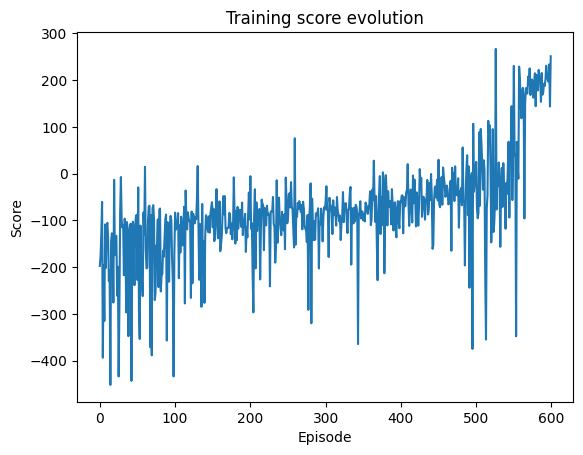

In [42]:
environment, number_of_observations, number_of_actions = create_environment()
agent = DQN(number_of_observations, number_of_actions)

episode = 0
start_time = time.perf_counter()
total_steps = 0
goal_reached = False

def epsilon_by_step(step):
    if step < WARMUP_STEPS:
        return 1.0
    step2 = step - WARMUP_STEPS
    decay = (EPSILON_START - EPSILON_END) / EPSILON_DECAY_STEPS
    return max(EPSILON_END, EPSILON_START - decay * step2)

def evaluate_greedy(agent, env, n_episodes=10):
    scores = []
    for i in range(n_episodes):
        s, _ = env.reset()  # sin seed fijo
        done = False
        total = 0.0
        while not done:
            a = agent.select_greedy_policy(s)
            s, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated
            total += r
        scores.append(total)
    return float(np.mean(scores))

nstep_buffer = deque(maxlen=N_STEP)

def flush_nstep_buffer(agent, buffer, gamma):
    """
    Vacía el buffer acumulando retornos n-step para las transiciones restantes
    (al final de episodio).
    """
    while len(buffer) > 0:
        R = 0.0
        for i, (_, _, r, _, _) in enumerate(buffer):
            R += (gamma ** i) * r

        s0, a0, _, _, _ = buffer[0]
        _, _, _, s_last, done_last = buffer[-1]

        agent.remember(s0, a0, R, s_last, done_last)
        buffer.popleft()

while (episode < MAX_EPISODES_FOR_TRAINING) and not(goal_reached):
    episode += 1
    score = 0.0
    state, info = environment.reset(seed=SEED + episode)
    done = False

    while not done:
        exploration_rate = epsilon_by_step(total_steps)
        action = agent.select(state, exploration_rate)

        state_next, reward, terminated, truncated, info = environment.step(action)
        done = terminated or truncated
        done_for_target = terminated  # solo terminal real

        total_steps += 1
        score += reward

        # --- N-step buffer ---
        nstep_buffer.append((state, action, reward, state_next, done_for_target))

        # cuando tenemos N transiciones, empujamos una transición N-step al replay
        if len(nstep_buffer) == N_STEP:
            R = 0.0
            for i, (_, _, r, _, _) in enumerate(nstep_buffer):
                R += (GAMMA ** i) * r

            s0, a0, _, _, _ = nstep_buffer[0]
            _, _, _, sN, doneN = nstep_buffer[-1]

            agent.remember(s0, a0, R, sN, doneN)

        # aprender (igual que antes)
        if (total_steps >= WARMUP_STEPS) and (total_steps % TRAIN_EVERY == 0):
            # si usas PER:
            # agent.learn(total_steps)
            # si NO usas PER:
            agent.learn(total_steps) if "global_step" in agent.learn.__code__.co_varnames else agent.learn()

        state = state_next

    # Empuja al replay las transiciones restantes del episodio (si quedaron < N_STEP)
    flush_nstep_buffer(agent, nstep_buffer, GAMMA)


    agent.add_score(score)
    average_score = agent.average_score(EPISODES_TO_CHECK_TRAINING_GOAL)

    print("Episode {0:>4}: ".format(episode), end='')
    print("score {0:>7} ".format(round(score, 2)), end='')
    print("(epsilon: %.3f, " % epsilon_by_step(total_steps), end='')
    print("avg(last {0}): {1:>6}, ".format(EPISODES_TO_CHECK_TRAINING_GOAL, round(average_score, 2)), end='')
    print("buffer: " + str(agent.memory.current_size) + ", steps: " + str(total_steps) + ")")


    if episode % 25 == 0:
        greedy_mean = evaluate_greedy(agent, environment, n_episodes=10)
        print(f"   >> Greedy eval (10 eps): {greedy_mean:.2f}")
        if (not hasattr(agent, "lr_dropped")) and (greedy_mean >= 200):
            agent.optimizer.learning_rate.assign(1e-4)
            agent.lr_dropped = True

        if greedy_mean > getattr(agent, "best_greedy", -1e9):
            agent.best_greedy = greedy_mean
            agent.model.save("best_model.keras")

        # criterio de parada REAL (el que importa para la práctica)
        if greedy_mean >= TRAINING_GOAL:
            print("✅ Stop: greedy_mean >= 200")
            goal_reached = True


    if (episode >= EPISODES_TO_CHECK_TRAINING_GOAL) and (average_score >= TRAINING_GOAL):
        goal_reached = True

print("Time for training: ", end='')
print_time(time.perf_counter() - start_time)
print("Total steps: ", total_steps)
print("Score (average last episodes):", round(average_score, 2))
print("Score (max):", round(max(agent.scores), 2))

agent.display_scores_graphically()
agent.model.save("last_model.keras")



## Testing program



In [44]:
agent.delete_scores()
episode = 0
start_time = time.perf_counter()
while (episode < EPISODES_TO_EVALUATE_MODEL_PERFORMANCE):
    episode += 1
    score = 0
    state, info = environment.reset()
    end_episode = False
    while not(end_episode):
        # Select an action for the current state
        action = agent.select_greedy_policy(state)

        # Execute the action in the environment
        state_next, reward, terminal_state, truncated, info = environment.step(action)

        score += reward

        # Detect end of episode and print
        if terminal_state or truncated:
            agent.add_score(score)
            print("Episode {0:>3}: ".format(episode), end = '')
            print("score {0:>3} \n".format(round(score)), end = '')
            end_episode = True
        else:
            state = state_next

print("Time for testing: ", end = '')
print_time(time.perf_counter() - start_time)
print("Score (average):", round(np.mean(agent.scores)))
print("Score (max):", round(max(agent.scores)))

Episode   1: score 210 
Episode   2: score 253 
Episode   3: score 306 
Episode   4: score 119 
Episode   5: score 217 
Episode   6: score 199 
Episode   7: score 249 
Episode   8: score 242 
Episode   9: score 234 
Episode  10: score 241 
Episode  11: score 264 
Episode  12: score 212 
Episode  13: score 222 
Episode  14: score 267 
Episode  15: score 117 
Episode  16: score 287 
Episode  17: score 249 
Episode  18: score 232 
Episode  19: score 209 
Episode  20: score 294 
Episode  21: score 198 
Episode  22: score 254 
Episode  23: score 239 
Episode  24: score 248 
Episode  25: score 254 
Episode  26: score 207 
Episode  27: score 238 
Episode  28: score 215 
Episode  29: score 242 
Episode  30: score 235 
Time for testing: 1 min 17 seconds
Score (average): 232
Score (max): 306
